In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity




In [4]:
df=pd.read_csv('spotify_millsongdata.csv')

In [5]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [6]:
df=df.sample(20000).drop('link', axis=1).reset_index(drop=True)


In [7]:
pp=df.copy()

In [8]:
pp['text'] = pp['text'].apply(lambda x: str(x).lower().replace(r'^\w\s',' ').replace(r'\n',' ',))

In [9]:
df['text']= df['text'].apply(lambda x :str(x).replace(r'\n\r',' '))

NOW that we have assigned the link to another column we can drop them


In [10]:
df.shape

(20000, 3)

In [11]:
artist_list=df.groupby('artist').count()

Now we are having 643 artist list in our dataset


In [12]:
artist_list.count()

song    639
text    639
dtype: int64

In [13]:
df['song']=df['song'].str.lower()

In [14]:
df['text'].str.count('\n').sum()

820005

In [15]:
df.columns

Index(['artist', 'song', 'text'], dtype='object')

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string


In [17]:

# import nltk
# it is a nlp library , it is used to process the text data
# from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KUSHAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In this the similar words which are having same meaning but differ in spelling are changed into one common word


In [18]:
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenization and lowercase conversion
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]  # Stopword and punctuation removal
    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)
     

In [19]:
# # import nltk
# # nltk.download('punkt')
# token(df['text'][0])
# token('hello world beautiful beauty')

In [20]:
df['cleaned text']=df['text'].apply(preprocess_text)

In [21]:

from sklearn.datasets import make_blobs
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

Here we are taking sample data for testing 


In [22]:
# Randomly sample a subset of song descriptions for clustering (adjust sample size as needed)
sample_size = 1000
random_indices = np.random.choice(len(df['cleaned text']), size=sample_size, replace=False)
sampled_descriptions = [df.iloc[i] for i in random_indices]

In [23]:
sampled_descriptions=pd.DataFrame(sampled_descriptions)

In [24]:
sampled_descriptions

,artist,song,text,cleaned text
14257,Josh Groban,my december,This is my December \r\nThis is my time of th...,This December This time year This December Thi...
5958,Devo,big mess,I am cowboy kim \r\nCowboy kim I am \r\nI am...,I cowboy kim Cowboy kim I I lucky cowboy Let t...
2143,George Strait,i saw god today,I just walked down the street to the coffee sh...,I walked street coffee shop Had take break I '...
7283,Matt Redman,now to live the life,Many are the words we speak \r\nMany are the ...,Many word speak Many song sing Many kind offer...
14964,Uncle Tupelo,sin city,"This old town is filled with sin, \r\nIt'll s...",This old town filled sin It 'll swallow If 've...
...,...,...,...,...
13141,Cher,i will wait for you,[Chorus] \r\nIf it takes forever \r\nI will ...,Chorus If take forever I wait For thousand sum...
2863,Iron Maiden,ghost of the navigator,"I have sailed to many lands, now I make my fin...",I sailed many land I make final journey On bow...
7963,Elvis Presley,fame and fortune,Fame and fortune \r\nHow empty they can be \...,Fame fortune How empty But I hold arm That 's ...
14719,Old 97's,in the satellite rides a star,Time knows you're done \r\nTime as you fall ...,Time know 're done Time fall I 'm middle lette...


we need to change it to data frame

now that we got the sampled data , we gonna do tfidf on that sampled data


In [25]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
tdif=TfidfVectorizer(analyzer='word', stop_words='english')

In [26]:
matrix=tdif.fit_transform(sampled_descriptions['cleaned text'])

In [33]:
print(matrix.shape)

(1000, 9138)


In [28]:
wcss = []
silhouette_scores = []

# Try different values of k (number of clusters) and compute WCSS and silhouette scores
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(matrix, kmeans.labels_))

C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The defaul

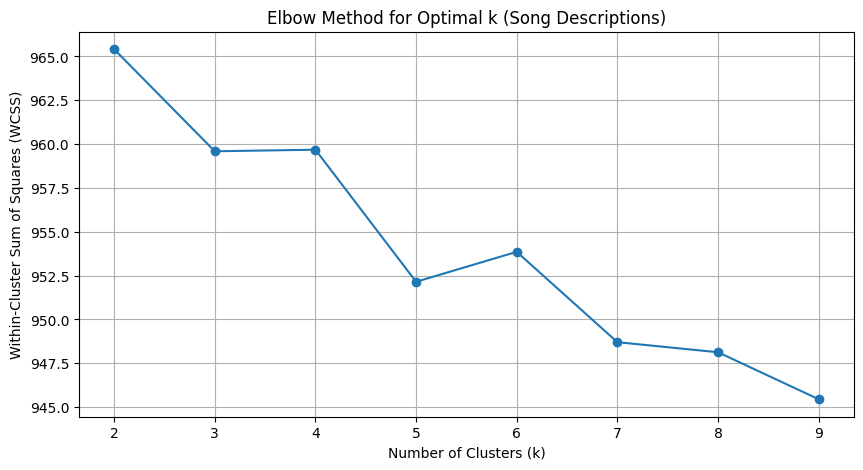

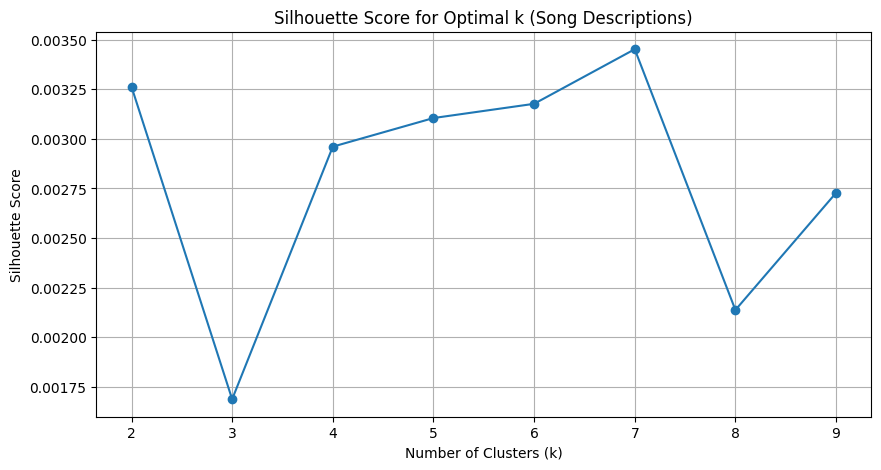

In [29]:
# Plotting Elbow Method (WCSS vs. Number of Clusters)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 10))
plt.grid(True)
plt.show()

# Plotting Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 10))
plt.grid(True)
plt.show()

after evauating the result of silhoueette and elbow method 

the value of k is 7 , as it is the optimal cluster for our data


In [32]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


C:\Users\KUSHAL\AppData\Local\Temp\ipykernel_16952\1069843014.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


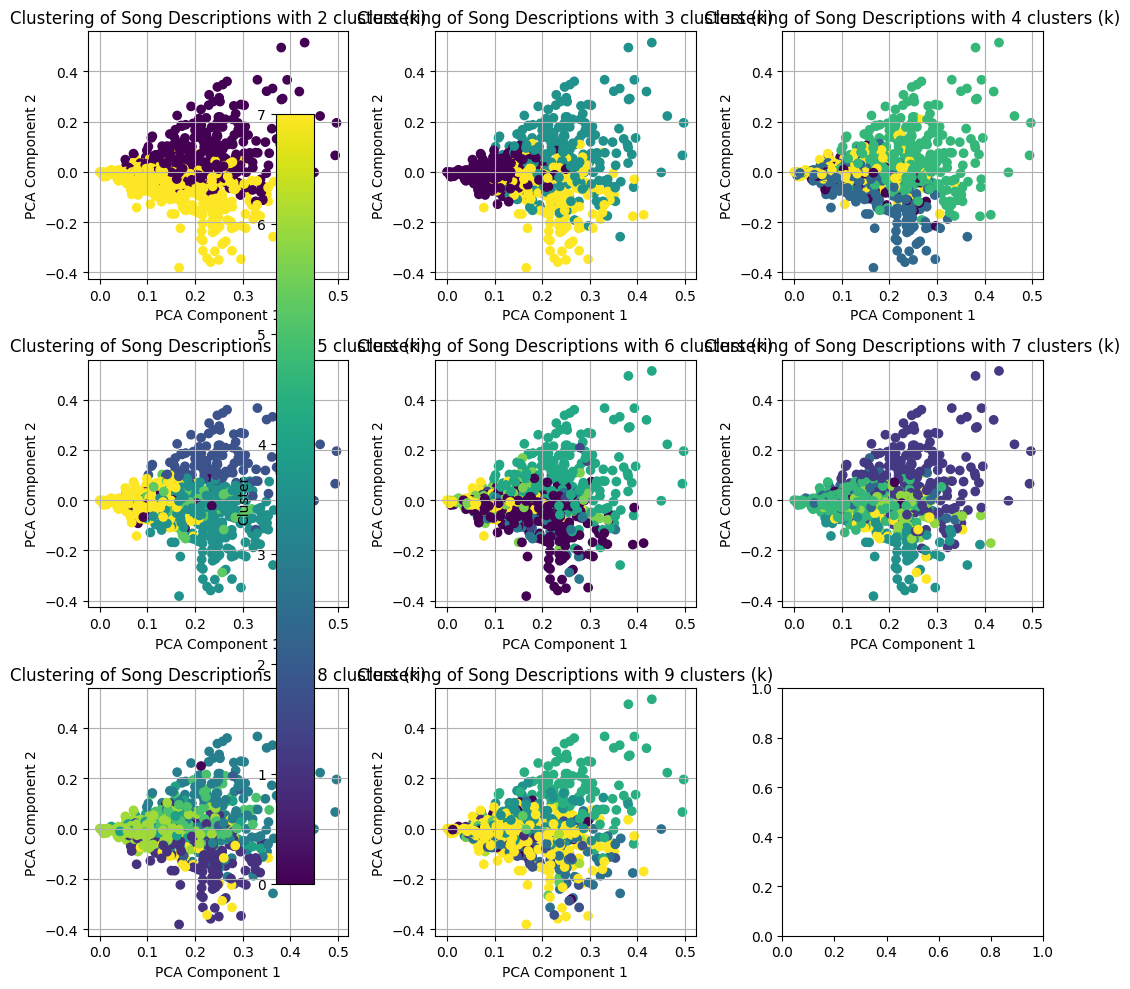

In [51]:
# Perform dimensionality reduction for visualization using PCA
svd = TruncatedSVD(n_components=2, random_state=0)
tfidf_svd = svd.fit_transform(matrix)
fig,axs=plt.subplots(3,3)
fig.set_size_inches(10, 10)
scatter_plots=[]
# Initialize MiniBatchKMeans clustering with optimal k (e.g., based on elbow method or silhouette score)
for i in range(2,10):
    k = i  # Example: Optimal number of clusters
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)

    # Get cluster labels and plot clusters in a scatter plot
    cluster_labels = kmeans.labels_
    scatter_plot = axs[int((i-2)/3),(i-2)%3].scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=cluster_labels, cmap='viridis')
    # plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=cluster_labels, cmap='viridis')
   
    axs[int((i - 2) / 3), (i - 2) % 3].set_xlabel('PCA Component 1')
    axs[int((i - 2) / 3), (i - 2) % 3].set_ylabel('PCA Component 2')
    axs[int((i - 2) / 3), (i - 2) % 3].set_title(f'Clustering of Song Descriptions with {i} clusters (k)')
    axs[int((i - 2) / 3), (i - 2) % 3].grid(True)

    scatter_plots.append(scatter_plot)  # Add scatter plot object to the list
   
plt.colorbar(scatter_plots[-2], ax=axs,location='left',pad=0.05, label='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.sparse import csr_matrix

# # Assuming 'matrix' is a sparse matrix in CSR format
# sparse_matrix = csr_matrix(matrix)

# # Compute cosine similarity using sparse matrices
similar = cosine_similarity(matrix)

In [ ]:
similar[0]

array([1.        , 0.00633337, 0.03004779, ..., 0.0441019 , 0.0122021 ,
       0.08368901])

In [ ]:
df['song']

0        we are never ever getting back together
1                               25 minutes to go
2                                    sue ann sir
3                                           once
4                            were are my panties
                          ...                   
19995                              flutes of chi
19996                                     autumn
19997                              disgustipated
19998                                 my sharona
19999                                 drop on by
Name: song, Length: 20000, dtype: object

In [ ]:
df[df['song']=="city's burning"].index[0]

4067

Now we are making recommder function for getting the songs


In [ ]:
def recommder(song_name):
    idx=df[df['song']==song_name].index[0]
    distance=sorted(list(enumerate(similar[idx])), key=lambda x: x[1], reverse=True)
    song=[]
    for s_id in distance[1:20]:
        song.append(df.iloc[s_id[0]].song)
    return song
    
    

In [ ]:
recommder("steel drivin' man")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
pp

,song,text
artist,,
'n Sync,28,28
ABBA,44,44
Ace Of Base,29,29
Adam Sandler,25,25
Adele,20,20
...,...,...
Zoegirl,11,11
Zornik,3,3
Zox,8,8


Now we are gonna do the dumping of our code to bytes through pickle with dump method

In [ ]:
def artist_songs(song_name):
    index_range=pp[pp['song']==song_name].artist
    artist_list=pp[pp['artist']==index_range.iloc[0]].song
    return artist_list

In [ ]:
pde=artist_songs('phony calls').tolist()

In [ ]:
pde

['toothless people',
 'gump',
 'one more minute',
 'alimony',
 'mr. frump in the iron lung',
 "frank's",
 'polkamon',
 'midnight star',
 "callin' in sick",
 'phony calls',
 "my baby's in love with eddie vedder",
 'tmz',
 'perform this way',
 'syndicated inc.',
 'george of the jungle',
 'mr. popeil',
 'my bologna',
 'traffic jam',
 'such a groovy guy',
 'fun zone',
 'another one rides the bus',
 'do i creep you out',
 'llama song',
 'talk soup',
 'smells like nirvana',
 'ricky',
 'germs',
 'cable tv',
 'jurassic park',
 'amish paradise',
 'one of those days',
 'the brady bunch',
 'melanie',
 'good enough for now']

In [ ]:
import pickle

In [ ]:
pickle.dump(similar, open('similar.pkl', 'wb'))

In [ ]:
pickle.dump(df, open('df.pkl', 'wb'))